In [75]:
!pip install tensorflow
!pip install imbalanced-learn

In [79]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

In [80]:
# Import the CSV files
df_train_original = pd.read_csv('./data/application_train.csv')
df_test_original = pd.read_csv('./data/application_test.csv')

### Perform a preprocessing step on the train data

In [81]:
# Drop columns with all NaN values
df_train_original = df_train_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_train_original) * 0.95
df_train_original = df_train_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_train_original = df_train_original.dropna()

# One-hot encode categorical variables
df_train_original = pd.get_dummies(df_train_original)

### Perform a preprocessing step on the test data

In [82]:
# Drop columns with all NaN values
df_test_original = df_test_original.dropna(axis=1, how='all')

# Drop columns with more than 95% NaN values
threshold = len(df_test_original) * 0.95
df_test_original = df_test_original.dropna(axis=1, thresh=threshold)

# Drop NaN values
df_test_original = df_test_original.dropna()

# One-hot encode categorical variables
df_test_original = pd.get_dummies(df_test_original)

### Remove columns from `df_train_original` that do not exist in `df_test_original`

In [83]:
intersection = list(set(df_train_original.columns) &
                  set(df_test_original.columns))
intersection.append("TARGET")

df_train_original = df_train_original[intersection]

In [ ]:
# Separate features and target variable from df_train
X = df_train_original
y = df_train_original['TARGET']

In [ ]:
# Define the SMOTE sampler
smote = SMOTE(sampling_strategy=0.5, k_neighbors=10,
              random_state=42, n_jobs=-1)

# Display the number of samples before SMOTE
print("Number of samples before SMOTE:")
print("X_train_scaled:", X.shape[0])
print("y_train:", y.shape[0])

# Apply SMOTE
X_train_balanced, y_train_balanced = smote.fit_resample(X, y)

# Display the number of samples after SMOTE
print("\nNumber of samples after SMOTE:")
print("X_train_balanced:", X_train_balanced.shape[0])
print("y_train_balanced:", y_train_balanced.shape[0])

Number of samples before SMOTE:
X_train_scaled: 304531
y_train: 304531


c:\Work\Home Credit Default Risk\.venv\lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(



Number of samples after SMOTE:
X_train_balanced: 419796
y_train_balanced: 419796


In [ ]:
X_train_balanced = X_train_balanced.drop(columns=['TARGET', 'SK_ID_CURR'])

In [84]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)

# Ensure df_test has the same columns as X_train
df_test_aligned = df_test_original[X_train.columns]

# Transform the test data
X_test_scaled = scaler.transform(df_test_aligned)

In [ ]:
len(X_train_scaled), len(X_train_balanced)

In [86]:
model = Sequential()
model.add(Dense(512, input_dim=X_train_balanced.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

c:\Work\Home Credit Default Risk\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [87]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Define early stopping
early_stopping = EarlyStopping(
monitor='val_loss', patience=5, restore_best_weights=True)

In [88]:
history = model.fit(X_train_balanced, y_train_balanced, validation_data=(
    X_val_scaled, y_val), epochs=100, batch_size=256, callbacks=[early_stopping])

Epoch 1/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 36s 21ms/step - accuracy: 0.6594 - loss: 0.6302 - val_accuracy: 0.7709 - val_loss: 0.4358
Epoch 2/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 41s 21ms/step - accuracy: 0.7240 - loss: 0.5467 - val_accuracy: 0.8041 - val_loss: 0.4133
Epoch 3/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.7591 - loss: 0.5064 - val_accuracy: 0.8357 - val_loss: 0.3804
Epoch 4/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.7773 - loss: 0.4786 - val_accuracy: 0.8702 - val_loss: 0.3475
Epoch 5/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.7893 - loss: 0.4589 - val_accuracy: 0.8776 - val_loss: 0.3452
Epoch 6/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 19s 15ms/step - accuracy: 0.8003 - loss: 0.4417 - val_accuracy: 0.8893 - val_loss: 0.3285
Epoch 7/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - accuracy: 0.8089 - loss: 0.4287 - val_accuracy: 0.8867 - val_loss: 0.3225
Epoch 8/100
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - accuracy: 

In [92]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_val_scaled, y_val)
print(f'Validation Accuracy: {val_accuracy}')


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9101 - loss: 0.2931
Validation Accuracy: 0.9107163548469543


1904/1904 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step


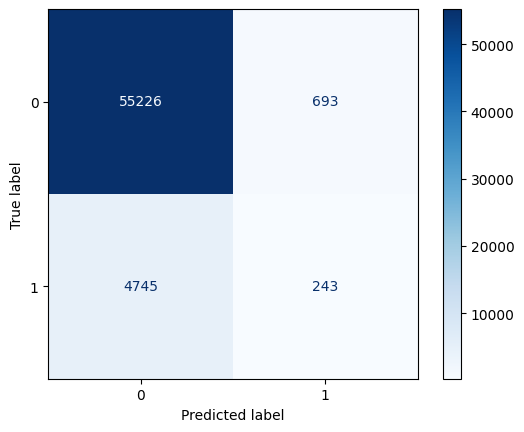

In [93]:
# Predict on the validation set
y_val_pred = model.predict(X_val_scaled).round().astype(int)

# Create the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [95]:
# Print classification report
print(classification_report(y_val, y_val_pred))

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f'ROC-AUC Score: {roc_auc}')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_val_pred)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     55919
           1       0.26      0.05      0.08      4988

    accuracy                           0.91     60907
   macro avg       0.59      0.52      0.52     60907
weighted avg       0.87      0.91      0.88     60907

ROC-AUC Score: 0.5181619975639813


In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_score))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [31]:
# Predict on the test set
df_test_original['TARGET'] = model.predict(X_test_scaled).round().astype(int)

# Export the predictions to a CSV file
df_test_original.to_csv('./outputs/enhanced_features_deep_learning/df_test_predictions_deep_learning.csv', index=False)

447/447 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
